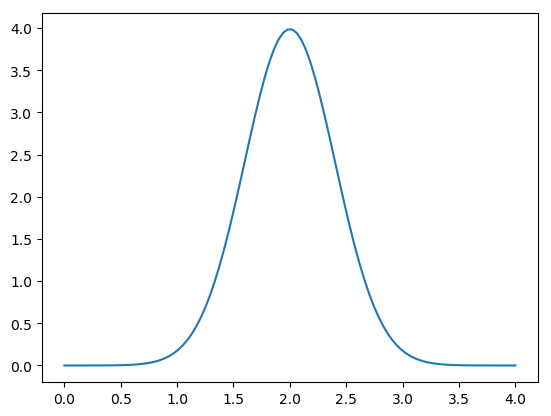

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x121961080>

In [1]:
using PyCall
include("src/gauss_error.jl")

a = 0.
b = 4.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x)# + norm(n2, mu2, sig2, x)
end

x = range(a, stop=b, length=100)

using PyPlot
myplot = plot(x, phi.(x))

In [3]:
function kernel(x::Float64, y::Float64)
    n = x-y
    if n>0
        return 1
    elseif n<0
        return 0
        else return 1.0/2
    end
end

kernel (generic function with 1 method)

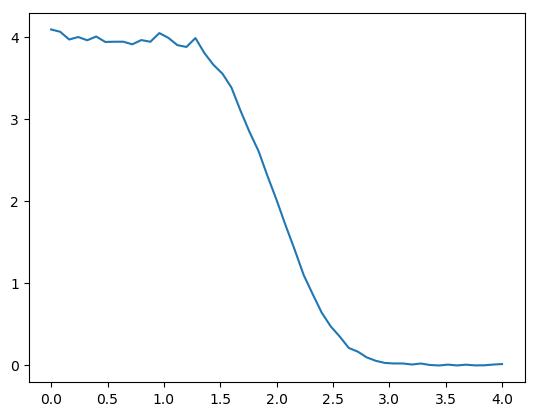

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13bcc9f28>

In [4]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = Float64[]
for i = 0:50
    push!(y, a + (b - a) * i/50)
end
ftrue = convolution.(y)
sig = 0.01*ftrue +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [5]:
basis = FourierBasis(a, b, 7)

FourierBasis(0.0, 4.0, 7, my_func[my_func(##14#18(), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 1), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 2), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 3), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 4), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 5), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 6), (0.0, 4.0)), my_func(##15#19{Float64,Float64,Int64}(2.0, 2.0, 7), (0.0, 4.0)), my_func(##16#20{Float64,Float64,Int64}(2.0, 2.0, 7), (0.0, 4.0))])

In [6]:
Kmn = discretizeKernel(basis, kernel, y)

51×15 Array{Float64,2}:
 2.0    9.22959e-17  -3.83565e-17  -6.57087e-16  …  -5.26226e-17  2.1842e-16 
 1.96   0.0797896     0.00501994   -0.0791604        0.0700749    0.0329747  
 1.92   0.158321      0.0200006    -0.153347         0.0893348    0.107987   
 1.88   0.234355      0.0447057    -0.217898         0.0438134    0.170642   
 1.84   0.306694      0.0787456    -0.268758        -0.0334793    0.175505   
 1.8    0.374196      0.121584     -0.302731     …  -0.0864945    0.119049   
 1.76   0.435796      0.172544     -0.317682        -0.076788     0.0422145  
 1.72   0.490524      0.230823     -0.312672        -0.0113985    0.000717134
 1.68   0.537516      0.295502     -0.288015         0.0622566    0.0246491  
 1.64   0.576031      0.36556      -0.245262         0.0907662    0.0966562  
 1.6    0.605461      0.439893     -0.187098     …   0.0534565    0.164522   
 1.56   0.625343      0.517329     -0.117178        -0.0226173    0.179034   
 1.52   0.635364      0.596646     -0.03

In [8]:
my_omega = omega(basis, 2)
model = model = GaussErrorMatrixUnfolder(my_omega)

GaussErrorMatrixUnfolder(Array{Float64,2}[[6.08807 0.0 … 0.0 0.0; 0.0 6.08807 … 0.0 0.0; … ; 0.0 0.0 … 14617.5 0.0; 0.0 0.0 … 0.0 0.0]], 15, "EmpiricalBayes", nothing)

In [11]:
result = solve_matrix(model, Kmn, f, sig)

starting solve_matrix
ending solve_matrix
starting solve_correct
starting optimal_alpha
starting optimize
ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "covariance" => [0.00222504 -0.00167264 … -1.54677e-6 -0.00575019; -0.0016726…
  "phi"        => [1.97946, 1.61214, -0.0286724, 0.615847, -0.0293355, 0.050013…
  "alphas"     => [0.5]

In [13]:
phivec = PhiVec(result["phi"], basis, result["covariance"])
result1 = Float64[]
for x0 in x
    push!(result1, call(phivec, x0))
end
println(result1)

[-0.0592947, -0.123985, -0.17824, -0.212426, -0.220969, -0.203385, -0.164321, -0.112585, -0.0593604, -0.0159506, 0.00850965, 0.00892888, -0.0146437, -0.0569128, -0.108245, -0.156415, -0.188855, -0.194968, -0.168068, -0.106556, -0.0141291, 0.101036, 0.227953, 0.355019, 0.472316, 0.573554, 0.657292, 0.727186, 0.791222, 0.860078, 0.944936, 1.05516, 1.19631, 1.36887, 1.56788, 1.78373, 2.00367, 2.21406, 2.40271, 2.56092, 2.68487, 2.77607, 2.84078, 2.88844, 2.92968, 2.97389, 3.02727, 3.09138, 3.16269, 3.23317, 3.29171, 3.32629, 3.32628, 3.28453, 3.1989, 3.07273, 2.91437, 2.7358, 2.55048, 2.37103, 2.20704, 2.06356, 1.94038, 1.83245, 1.73115, 1.62634, 1.50858, 1.37136, 1.21253, 1.03511, 0.846814, 0.658846, 0.483845, 0.333586, 0.21679, 0.137501, 0.0943318, 0.0807404, 0.0862704, 0.098529, 0.105516, 0.0978552, 0.0705014, 0.0235905, -0.037725, -0.104421, -0.165503, -0.210286, -0.230616, -0.222593, -0.187455, -0.131464, -0.0647923, 0.000350313, 0.0520095, 0.0807382, 0.0813783, 0.0540232, 0.00397526

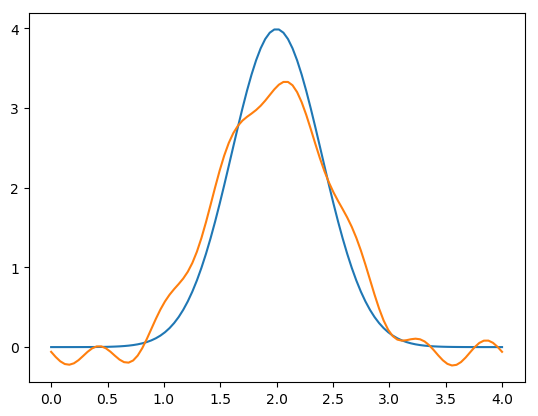

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14493a588>

In [15]:
plot(x, phi.(x))
plot(x, result1)